In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
wd = "/content/drive/MyDrive/Personal/Apziva"

For this project, I would recommend covering all the basics for modelling. Like EDA, feature engineering, evaluation metrics

This should include, confusion matrix, classification report, feature importance, ROC Curve
And it possible, Predicted Vs Observed charts

###Data Exploration

In [65]:
# Load data and check for NaNs
df = pd.read_csv(f"{wd}/ACME-HappinessSurvey2020.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [66]:
# X6 and X1 seem to be high in 0s
df

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <BR>
X1 = my order was delivered on time <BR>
X2 = contents of my order was as I expected <br>
X3 = I ordered everything I wanted to order<br>
X4 = I paid a good price for my order <br>
X5 = I am satisfied with my courier <br>
X6 = the app makes ordering easy for me

In [67]:
# Adding extra features
df["AVG"] = df.loc[:,"X1":"X6"].mean(axis=1)
df["avg_X2_X5"] = df.loc[:,"X2":"X5"].mean(axis=1)
df.sample(15)

,Y,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5
30,0,5,3,3,3,5,3,3.666667,3.50
86,1,5,3,3,3,5,5,4.000000,3.50
11,0,4,4,3,4,4,4,3.833333,3.75
18,0,5,1,2,4,4,5,3.500000,2.75
53,1,5,2,4,3,4,5,3.833333,3.25
39,1,4,4,3,4,2,4,3.500000,3.25
28,1,3,3,1,3,3,4,2.833333,2.50
69,1,5,4,5,5,5,5,4.833333,4.75
114,0,5,2,2,4,4,5,3.666667,3.00
0,0,3,3,3,4,2,4,3.166667,3.00


In [68]:
df = df[~((df["Y"] == 1) & (df["avg_X2_X5"] < 2))]
df = df[~((df['X1'] == 1) | (df['X6'] == 1)| (df['X2'] == 5)|(df['X3'] == 1))]

In [69]:
df

,Y,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5
0,0,3,3,3,4,2,4,3.166667,3.00
1,0,3,2,3,5,4,3,3.333333,3.50
2,1,5,3,3,3,3,5,3.666667,3.00
3,0,5,4,3,3,3,5,3.833333,3.25
4,0,5,4,3,3,3,5,3.833333,3.25
...,...,...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3,3.500000,3.25
122,1,5,2,3,4,2,5,3.500000,2.75
123,1,5,3,3,4,4,5,4.000000,3.50
124,0,4,3,3,4,4,5,3.833333,3.50


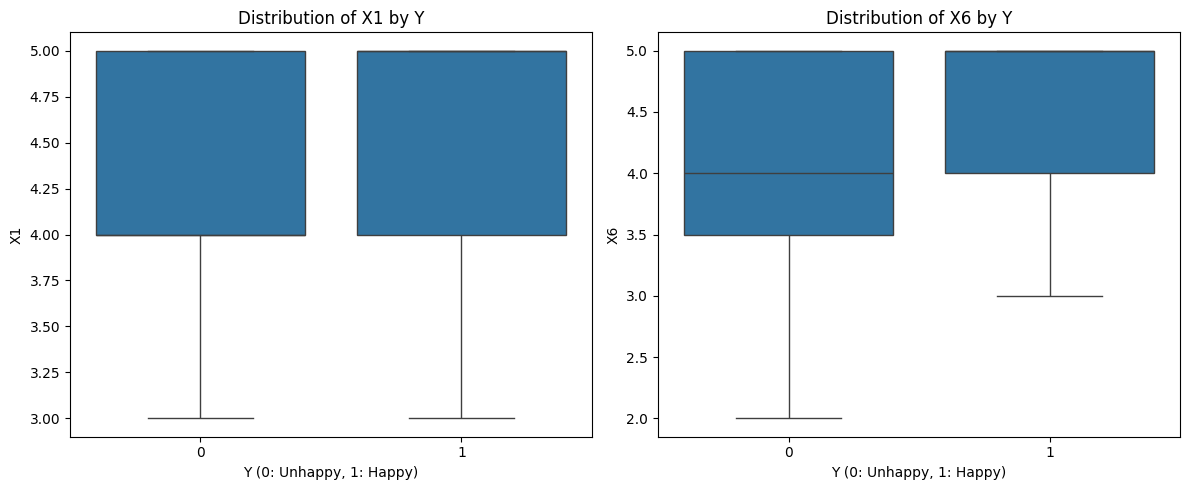

In [70]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot for X1 by Y on the first subplot
sns.boxplot(x='Y', y='X1', data=df, ax=axes[0])
axes[0].set_title('Distribution of X1 by Y')
axes[0].set_xlabel('Y (0: Unhappy, 1: Happy)')
axes[0].set_ylabel('X1')

# Box plot for X6 by Y on the second subplot
sns.boxplot(x='Y', y='X6', data=df, ax=axes[1])
axes[1].set_title('Distribution of X6 by Y')
axes[1].set_xlabel('Y (0: Unhappy, 1: Happy)')
axes[1].set_ylabel('X6')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

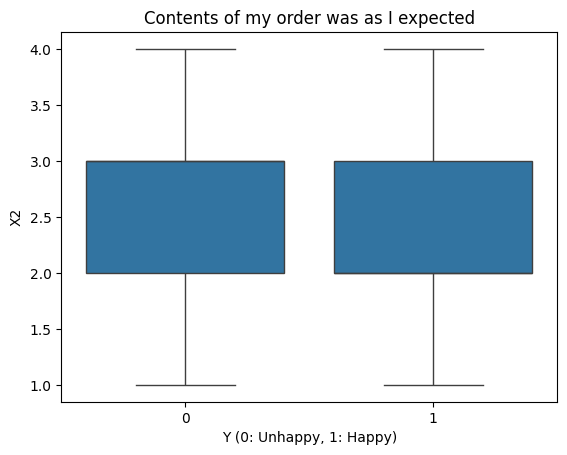

In [71]:
#X2 = contents of my order was as I expected
sns.boxplot(x='Y', y='X2', data=df)
plt.title('Contents of my order was as I expected')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

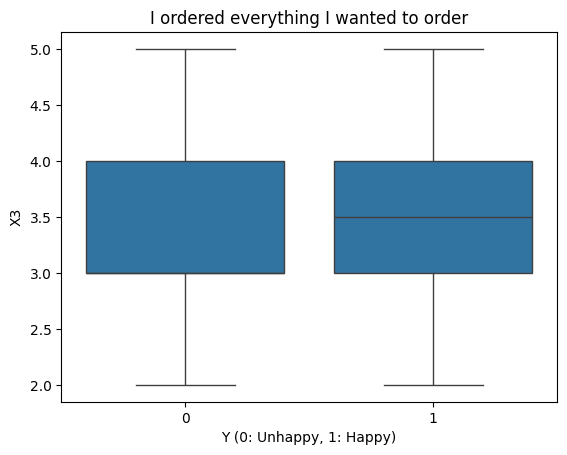

In [72]:
sns.boxplot(x='Y', y='X3', data=df)
plt.title('I ordered everything I wanted to order')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

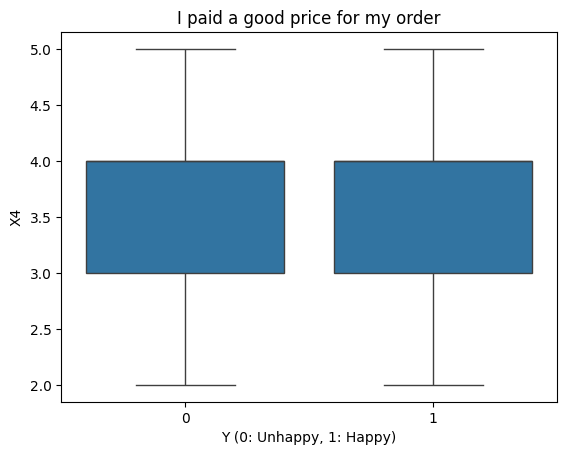

In [73]:
sns.boxplot(x='Y', y='X4', data=df)
plt.title('I paid a good price for my order')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

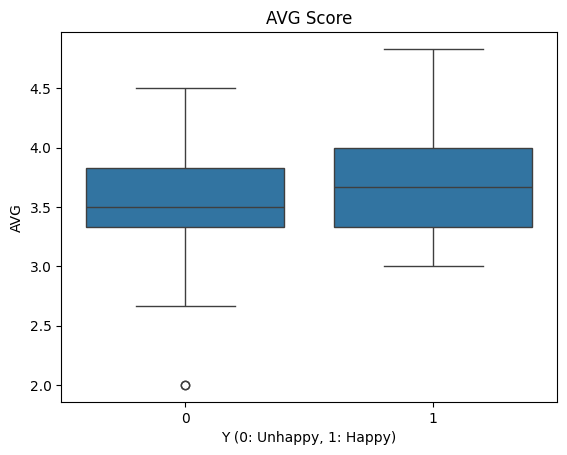

In [74]:
sns.boxplot(x='Y', y='AVG', data=df)
plt.title('AVG Score')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

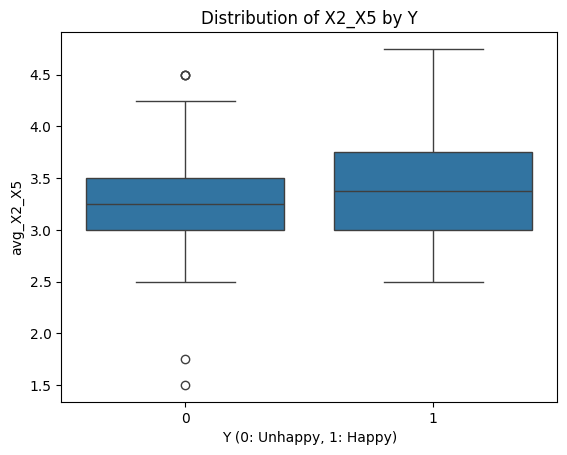

In [75]:
sns.boxplot(x='Y', y='avg_X2_X5', data=df)
plt.title('Distribution of X2_X5 by Y')
plt.xlabel('Y (0: Unhappy, 1: Happy)')
plt.show()

###Data Prep

In [76]:
y = df["Y"]
x = df.iloc[:,1:]
x

,X1,X2,X3,X4,X5,X6,AVG,avg_X2_X5
0,3,3,3,4,2,4,3.166667,3.00
1,3,2,3,5,4,3,3.333333,3.50
2,5,3,3,3,3,5,3.666667,3.00
3,5,4,3,3,3,5,3.833333,3.25
4,5,4,3,3,3,5,3.833333,3.25
...,...,...,...,...,...,...,...,...
121,5,2,3,4,4,3,3.500000,3.25
122,5,2,3,4,2,5,3.500000,2.75
123,5,3,3,4,4,5,4.000000,3.50
124,4,3,3,4,4,5,3.833333,3.50


In [77]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

###XGBoost

In [78]:
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred_train = bst.predict(X_train)
y_preds_test = bst.predict(X_test)

In [79]:
# AVG	avg_X2_X5
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_preds_test))

Train Metrics
              precision    recall  f1-score   support

           0       0.76      0.55      0.64        40
           1       0.70      0.86      0.77        50

    accuracy                           0.72        90
   macro avg       0.73      0.71      0.71        90
weighted avg       0.73      0.72      0.71        90

Test Metrics
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.54      0.58      0.56        12

    accuracy                           0.52        23
   macro avg       0.52      0.52      0.52        23
weighted avg       0.52      0.52      0.52        23



In [ ]:
#AVG
print("Train Metrics")
print(classification_report(y_train, y_pred_train))
print("Test Metrics")
print(classification_report(y_test, y_preds_test))

Train Metrics
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        50
           1       0.72      0.76      0.74        63

    accuracy                           0.70       113
   macro avg       0.70      0.69      0.69       113
weighted avg       0.70      0.70      0.70       113

Test Metrics
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.50      0.67      0.57         6

    accuracy                           0.54        13
   macro avg       0.55      0.55      0.54        13
weighted avg       0.55      0.54      0.53        13



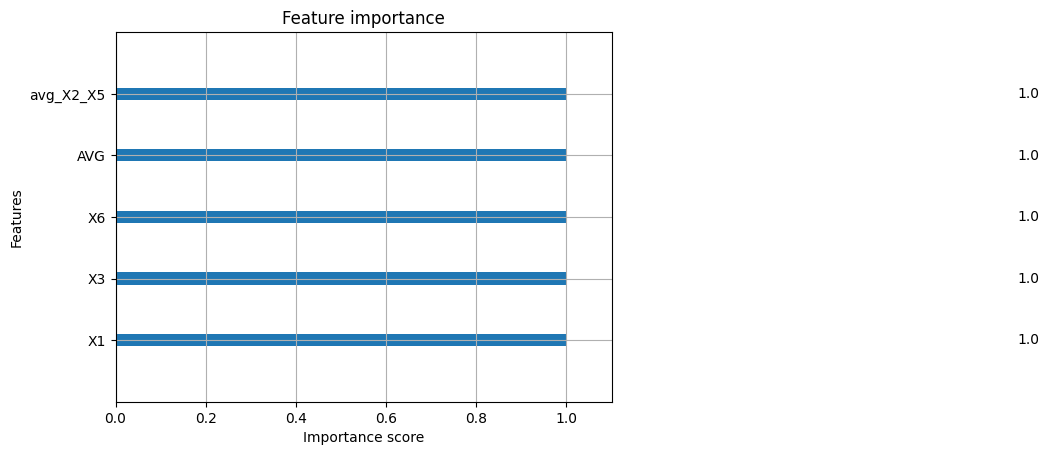

In [64]:
plot_importance(bst)
plt.show()

###Random Forest

In [ ]:
# Random Forrest prediction and importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_test = rf.predict(X_test)
print("Test accuracy:",accuracy_score(y_test, y_pred_test))
y_pred_train = rf.predict(X_train)
print("train accuracy:", accuracy_score(y_train, y_pred_train))

Test accuracy: 0.6153846153846154
train accuracy: 0.8761061946902655


In [ ]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
import eli5
eli5.show_weights(rf, feature_names = X.columns.tolist())

Weight,Feature
0.2243 ± 0.2269,AVG
0.1570 ± 0.1951,X1
0.1342 ± 0.1838,X6
0.1324 ± 0.1735,X5
0.1237 ± 0.1535,X3
0.1232 ± 0.1499,X2
0.1052 ± 0.1487,X4


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.57      0.67      0.62         6

    accuracy                           0.62        13
   macro avg       0.62      0.62      0.62        13
weighted avg       0.62      0.62      0.62        13

